In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
!pip install torchsummary
from torchsummary import summary
from matplotlib import pyplot as plt
import torch.optim as optim
from tqdm import tqdm

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
Batch_size = 4

In [ ]:
trainset = datasets.CIFAR10(root='../input/cifar10/cifar-10-python',train=True,download=True, transform=transform)
testset = datasets.CIFAR10(root='../input/cifar10/cifar-10-python',train=False,download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_size,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_size,shuffle=True, num_workers=2)

100%|██████████| 170498071/170498071 [00:05<00:00, 29396108.21it/s]


Extracting ../input/cifar10/cifar-10-python/cifar-10-python.tar.gz to ../input/cifar10/cifar-10-python
Files already downloaded and verified


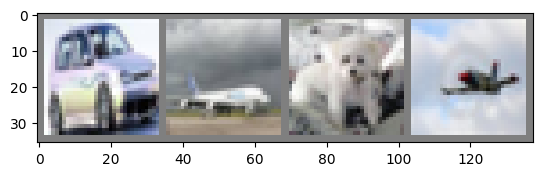

1 0 5 0


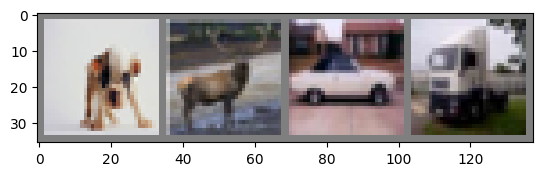

5 4 1 9


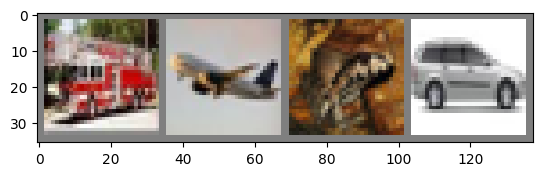

9 0 6 1


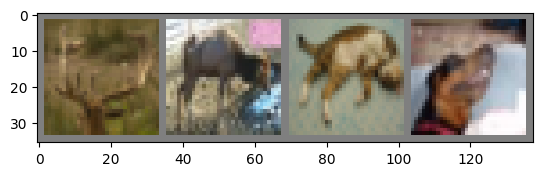

4 4 3 5


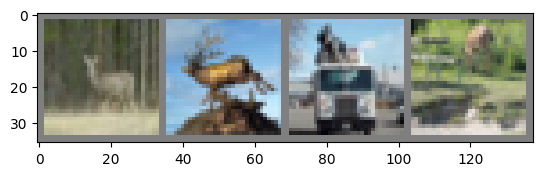

4 4 9 4


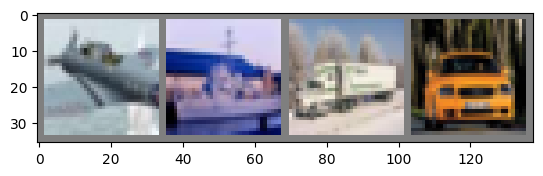

0 8 9 1


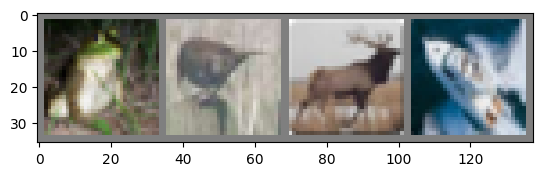

6 2 4 8


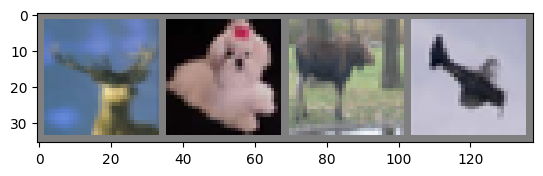

4 5 4 0


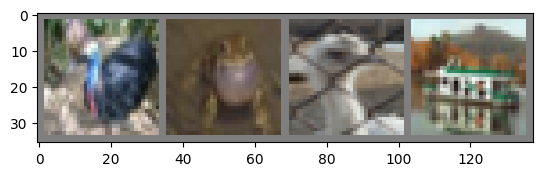

2 6 2 8


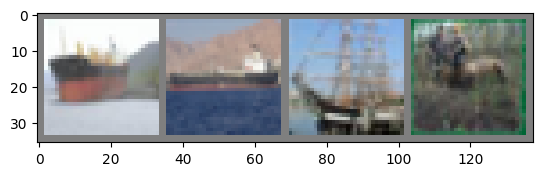

8 8 8 4


------------------------------------------------------------------------------------------


In [ ]:
import numpy as np
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



num_images_to_display = 10
count = 0


for images, labels in trainloader:
    imshow(torchvision.utils.make_grid(images))
    print(' '.join(f'{label}' for label in labels))
    count += 1
    if count == num_images_to_display:
        break
print("\n\n------------------------------------------------------------------------------------------")

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5,self).__init__()
        self.conv1 = nn.Sequential(

            nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5,stride=1, padding=0),

            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
        )
        self.conv2 = nn.Sequential(

            nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5,stride=1, padding=0),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
        )
        self.fc = nn.Sequential(

            nn.Linear(16*5*5,120),
            nn.ReLU(),
            nn.Linear(120,84),
            nn.ReLU(),
            nn.Linear(84,10),
        )


    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)


        x = x.view(x.size()[0],-1)
        x = self.fc(x)
        return x

net = LeNet5().to(device)

In [ ]:
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

In [ ]:
net =LeNet5().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)

    torch.backends.cudnn.benchmark = True

In [ ]:

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.01 ,patience = 1,min_lr = 0.000001)

epoch = 5

In [ ]:
net =LeNet5().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)

    torch.backends.cudnn.benchmark = True

In [ ]:
net.cuda()


DataParallel(
  (module): LeNet5(
    (conv1): Sequential(
      (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc): Sequential(
      (0): Linear(in_features=400, out_features=120, bias=True)
      (1): ReLU()
      (2): Linear(in_features=120, out_features=84, bias=True)
      (3): ReLU()
      (4): Linear(in_features=84, out_features=10, bias=True)
    )
  )
)

In [ ]:

ep_loss = []
for e in tqdm(range(epoch)):
  r_loss = 0.0
  for i,data in enumerate(trainloader,0):
    ip,lb = data
    ip,lb = ip.cuda(),lb.cuda()
    optimizer.zero_grad()
    op = net(ip)
    loss = criterion(op,lb)
    loss.backward()
    optimizer.step()
    r_loss += loss.item()
    if i % 1000 == 999:
      print(f'[{e + 1}, {i + 1:5d}] loss: {r_loss / 1000:.3f}')
      r_loss = 0.0
  # avg_loss = r_loss / len(trainloader)  # Calculate average loss for the epoch
  # scheduler.step(avg_loss)

print("Traning done")
# torch.save(net.state_dict(), 'model_weights.pth')

  0%|          | 0/5 [00:00<?, ?it/s]

[1,  1000] loss: 2.304
[1,  2000] loss: 2.304
[1,  3000] loss: 2.304
[1,  4000] loss: 2.303
[1,  5000] loss: 2.304
[1,  6000] loss: 2.305
[1,  7000] loss: 2.304
[1,  8000] loss: 2.305
[1,  9000] loss: 2.304
[1, 10000] loss: 2.303
[1, 11000] loss: 2.305
[1, 12000] loss: 2.303


 20%|██        | 1/5 [00:59<03:59, 59.79s/it]

[2,  1000] loss: 2.304
[2,  2000] loss: 2.305
[2,  3000] loss: 2.304
[2,  4000] loss: 2.306


 20%|██        | 1/5 [01:21<05:27, 81.85s/it]


KeyboardInterrupt: ignored

**Testing the accuracy of the model**

In [ ]:
correct = 0
total = 0

net.eval()

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.cuda(),labels.cuda()
        outputs = net(inputs)

        _, predicted = torch.max(outputs.data, 1)


        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the accuracy
accuracy = 100 * correct / total
print(f'Accuracy on the test dataset: {accuracy:.2f}%')

In [ ]:

import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Put the model in evaluation mode
net.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs = inputs.cuda()
        outputs = net(inputs)

        # Get the predicted class for each sample
        _, predicted = torch.max(outputs.data, 1)

        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

# Calculate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Calculate the accuracy for each class
class_accuracy = confusion.diagonal() / confusion.sum(axis=1)

# Print accuracy for each class
for i, acc in enumerate(class_accuracy):
    print(f'Accuracy for class {i}: {acc * 100:.2f}%')

# Calculate overall accuracy
overall_accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Overall accuracy: {overall_accuracy * 100:.2f}%')

TypeError: ignored

# **2. Dataset Augementation**

In [ ]:
transform = transforms.Compose([
    transforms.RandomCrop(32,padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
Batch_size = 1
trainset = datasets.CIFAR10(root='../input/cifar10/cifar-10-python',train=True,download=True, transform=transform)
testset = datasets.CIFAR10(root='../input/cifar10/cifar-10-python',train=False,download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_size,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_size,shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


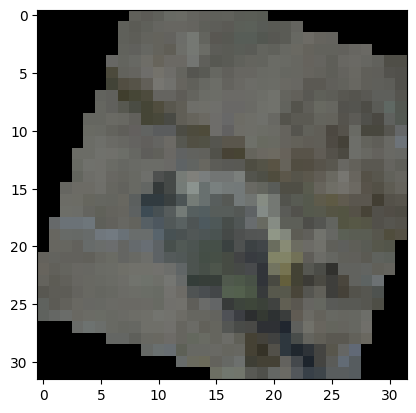

2


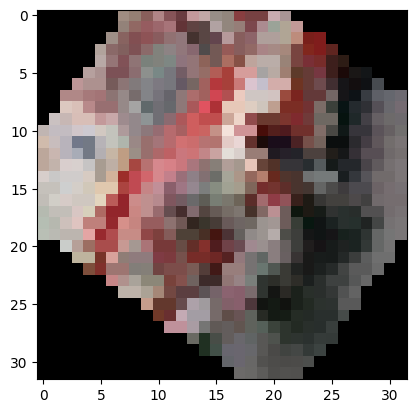

9


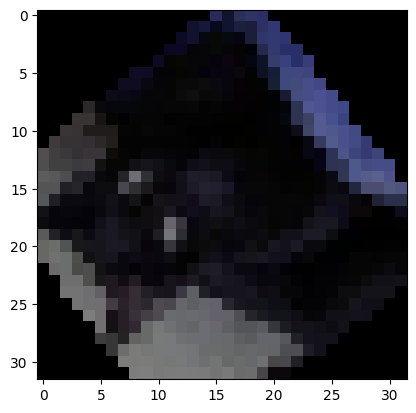

3


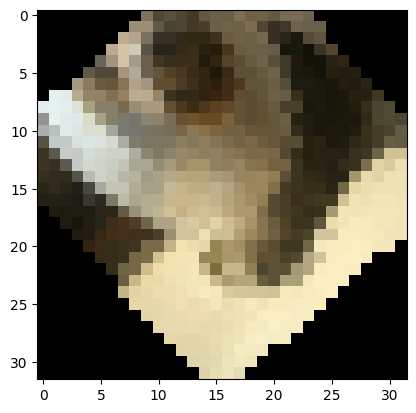

3


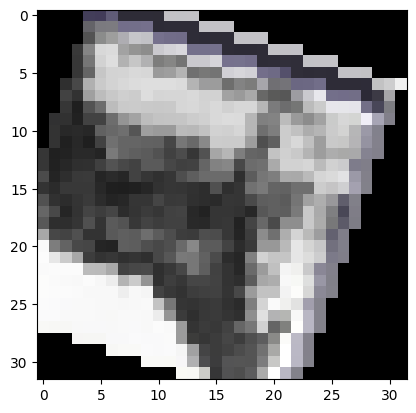

7


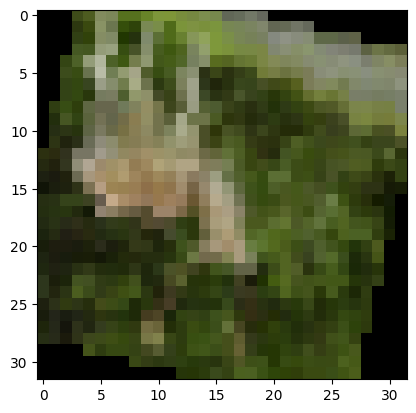

4


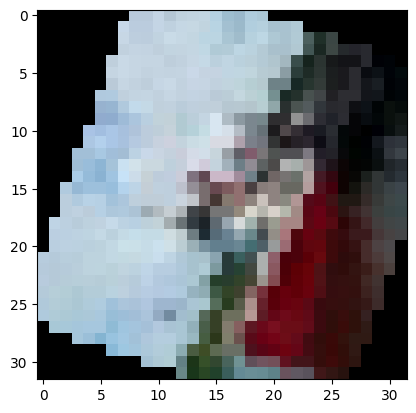

8


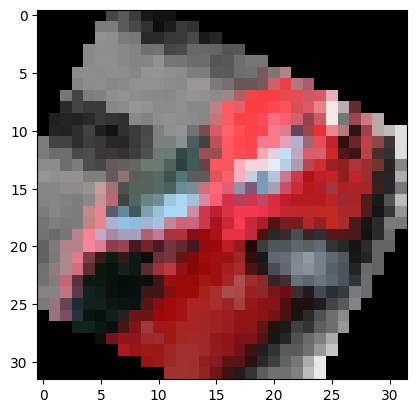

1


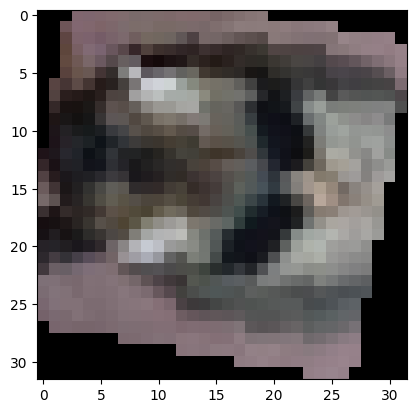

3


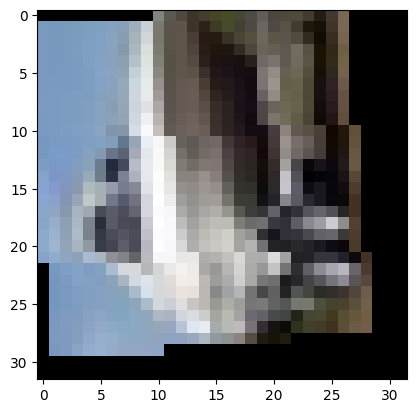

8


------------------------------------------------------------------------------------------


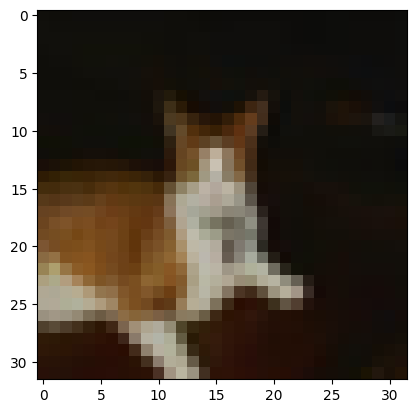

3


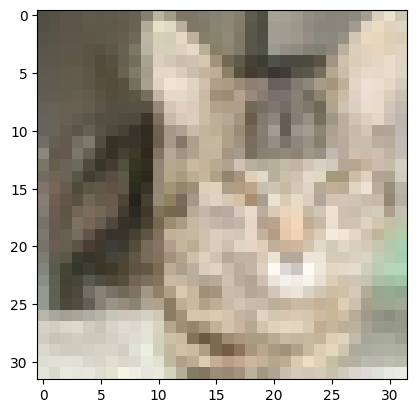

3


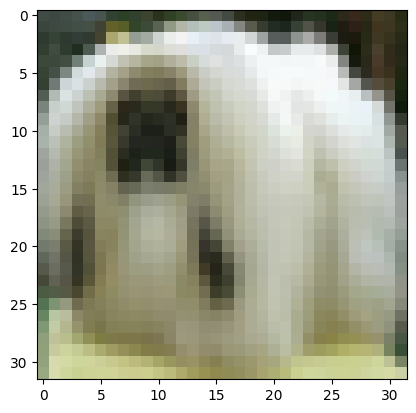

5


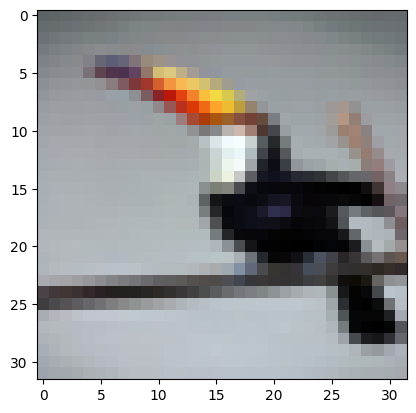

2


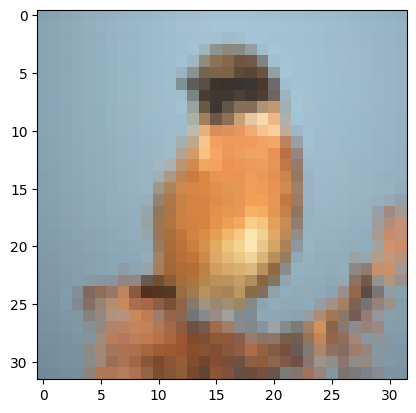

2


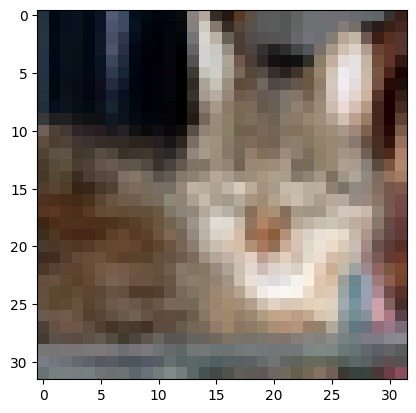

3


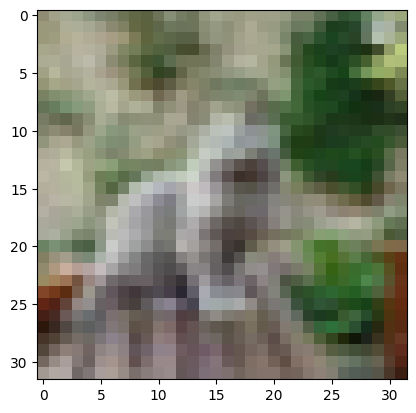

3


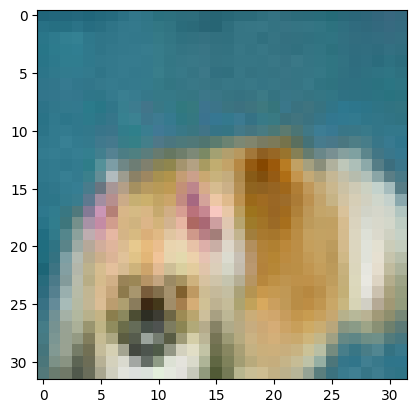

5


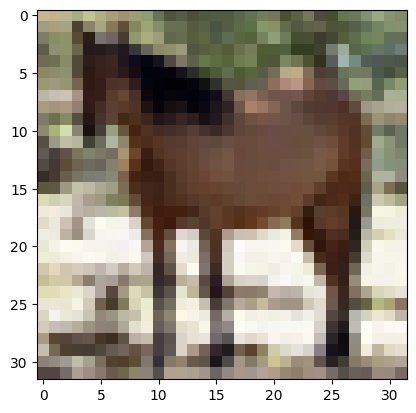

7


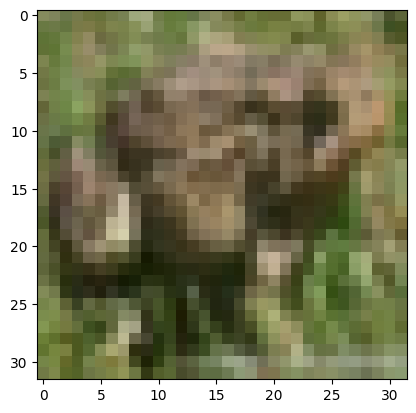

6


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



num_images_to_display = 10
count = 0


for images, labels in trainloader:
    imshow(torchvision.utils.make_grid(images))
    print(' '.join(f'{label}' for label in labels))
    count += 1
    if count == num_images_to_display:
        break
print("\n\n------------------------------------------------------------------------------------------")

In [ ]:
print(len(images))

1


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5,self).__init__()
        self.conv1 = nn.Sequential(

            nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5,stride=1, padding=0),

            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
        )
        self.conv2 = nn.Sequential(

            nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5,stride=1, padding=0),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
        )
        self.fc = nn.Sequential(

            nn.Linear(16*5*5,120),
            nn.ReLU(),
            nn.Linear(120,84),
            nn.ReLU(),
            nn.Linear(84,10),
        )


    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)


        x = x.view(x.size()[0],-1)
        x = self.fc(x)
        return x

net = LeNet5().to(device)

In [ ]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5 ,patience = 5,min_lr = 0.000001)

#import time
epoch = 5

In [ ]:
net =LeNet5().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)

    torch.backends.cudnn.benchmark = True
net.cuda()
from tqdm import tqdm
ep_loss = []
for e in tqdm(range(epoch)):
  r_loss = 0.0
  for i,data in enumerate(trainloader,0):
    ip,lb = data
    ip,lb = ip.cuda(),lb.cuda()
    optimizer.zero_grad()
    op = net(ip)
    loss = criterion(op,lb)
    loss.backward()
    optimizer.step()
    r_loss += loss.item()
    if i % 1000 == 999:
      print(f'[{e + 1}, {i + 1:5d}] loss: {r_loss / 1000:.3f}')


      r_loss = 0.0

print("Traning done")
torch.save(net.state_dict(), 'model_weights.pth')

  0%|          | 0/5 [00:00<?, ?it/s]

[1,  1000] loss: 2.304
[1,  2000] loss: 2.308
[1,  3000] loss: 2.309
[1,  4000] loss: 2.303
[1,  5000] loss: 2.300
[1,  6000] loss: 2.302


  0%|          | 0/5 [00:27<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
correct = 0
total = 0

net.eval()

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.cuda(),labels.cuda()
        outputs = net(inputs)

        _, predicted = torch.max(outputs.data, 1)


        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the accuracy
accuracy = 100 * correct / total
print(f'Accuracy on the test dataset: {accuracy:.2f}%')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

# Define the LeNet-5 architecture
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)


net = LeNet5()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


num_epochs = 5
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader, position=0, leave=True), 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:
            print(f"[{epoch + 1}, {i + 1}] Loss: {running_loss / 200:.3f}")
            running_loss = 0.0

print("Finished Training")

# Testing the model
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in tqdm(testloader, position=0, leave=True):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on the test set: {accuracy:.2f}%")


100%|██████████| 170498071/170498071 [00:02<00:00, 73565614.10it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


 26%|██▌       | 205/782 [00:04<00:16, 34.36it/s]

[1, 200] Loss: 2.303


 52%|█████▏    | 407/782 [00:09<00:06, 55.32it/s]

[1, 400] Loss: 2.301


 78%|███████▊  | 609/782 [00:12<00:03, 56.54it/s]

[1, 600] Loss: 2.297


 27%|██▋       | 210/782 [00:05<00:11, 51.48it/s]

[2, 200] Loss: 2.266


 52%|█████▏    | 408/782 [00:08<00:06, 54.52it/s]

[2, 400] Loss: 2.203


 77%|███████▋  | 606/782 [00:12<00:03, 48.34it/s]

[2, 600] Loss: 2.086


 26%|██▌       | 205/782 [00:03<00:10, 53.02it/s]

[3, 200] Loss: 1.906


 52%|█████▏    | 405/782 [00:07<00:07, 50.76it/s]

[3, 400] Loss: 1.884


 77%|███████▋  | 605/782 [00:12<00:04, 39.66it/s]

[3, 600] Loss: 1.820


 26%|██▋       | 207/782 [00:03<00:10, 56.96it/s]

[4, 200] Loss: 1.747


 52%|█████▏    | 404/782 [00:08<00:11, 33.50it/s]

[4, 400] Loss: 1.729


 78%|███████▊  | 609/782 [00:12<00:03, 51.37it/s]

[4, 600] Loss: 1.685


 26%|██▌       | 202/782 [00:03<00:11, 48.76it/s]

[5, 200] Loss: 1.650


 52%|█████▏    | 408/782 [00:08<00:07, 49.47it/s]

[5, 400] Loss: 1.626


 78%|███████▊  | 609/782 [00:12<00:03, 54.65it/s]

[5, 600] Loss: 1.603


 26%|██▌       | 203/782 [00:05<00:10, 54.29it/s]

[6, 200] Loss: 1.569


 52%|█████▏    | 407/782 [00:08<00:06, 54.28it/s]

[6, 400] Loss: 1.528


 78%|███████▊  | 609/782 [00:12<00:03, 56.99it/s]

[6, 600] Loss: 1.541


 26%|██▌       | 203/782 [00:04<00:15, 36.78it/s]

[7, 200] Loss: 1.509


 52%|█████▏    | 404/782 [00:08<00:07, 48.44it/s]

[7, 400] Loss: 1.482


 77%|███████▋  | 604/782 [00:13<00:04, 41.18it/s]

[7, 600] Loss: 1.468


 27%|██▋       | 210/782 [00:04<00:11, 51.28it/s]

[8, 200] Loss: 1.431


 52%|█████▏    | 404/782 [00:08<00:10, 35.17it/s]

[8, 400] Loss: 1.422


 77%|███████▋  | 603/782 [00:12<00:03, 53.37it/s]

[8, 600] Loss: 1.426


 26%|██▋       | 206/782 [00:04<00:15, 36.04it/s]

[9, 200] Loss: 1.404


 52%|█████▏    | 406/782 [00:08<00:07, 50.49it/s]

[9, 400] Loss: 1.376


 78%|███████▊  | 609/782 [00:12<00:02, 58.10it/s]

[9, 600] Loss: 1.368


 26%|██▌       | 205/782 [00:05<00:12, 47.33it/s]

[10, 200] Loss: 1.356


 52%|█████▏    | 407/782 [00:09<00:06, 57.23it/s]

[10, 400] Loss: 1.332


 78%|███████▊  | 608/782 [00:12<00:03, 47.12it/s]

[10, 600] Loss: 1.350


100%|██████████| 782/782 [00:17<00:00, 44.81it/s]


Finished Training


100%|██████████| 157/157 [00:02<00:00, 52.38it/s]

Accuracy on the test set: 52.34%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from tqdm import tqdm

# Define the LeNet-5 architecture
# class LeNet5(nn.Module):
#     def __init__(self):
#         super(LeNet5, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
#         self.relu1 = nn.ReLU()
#         self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
#         self.relu2 = nn.ReLU()
#         self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.relu3 = nn.ReLU()
#         self.fc2 = nn.Linear(120, 84)
#         self.relu4 = nn.ReLU()
#         self.fc3 = nn.Linear(84, 10)`

#     def forward(self, x):
#         x = self.pool1(self.relu1(self.conv1(x)))
#         x = self.pool2(self.relu2(self.conv2(x)))
#         x = x.view(-1, 16 * 5 * 5)
#         x = self.relu3(self.fc1(x))
#         x = self.relu4(self.fc2(x))
#         x = self.fc3(x)
#         return x


class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 120)
        self.relu4 = nn.ReLU()

        self.fc2 = nn.Linear(120, 84)
        self.relu5 = nn.ReLU()

        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))

        x = x.view(-1, 128 * 4 * 4)

        x = self.relu4(self.fc1(x))
        x = self.relu5(self.fc2(x))
        x = self.fc3(x)

        return x




# Load CIFAR-10 dataset and apply transformations
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomCrop(32, padding=4),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)
# Initialize the model and optimizer with weight decay
net = LeNet5()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001,weight_decay=1e-4)  # Add weight decay here

# Training loop
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 200:.3f}")
            running_loss = 0.0

print("Training finished.")
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in tqdm(testloader, position=0, leave=True):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on the test set: {accuracy:.2f}%")

Files already downloaded and verified
Files already downloaded and verified
[1, 200] loss: 1.950
[1, 400] loss: 1.641
[1, 600] loss: 1.484
[2, 200] loss: 1.279
[2, 400] loss: 1.227
[2, 600] loss: 1.188
[3, 200] loss: 1.078
[3, 400] loss: 1.076
[3, 600] loss: 1.002
[4, 200] loss: 0.936
[4, 400] loss: 0.934
[4, 600] loss: 0.898
[5, 200] loss: 0.876
[5, 400] loss: 0.850
[5, 600] loss: 0.837
Training finished.


100%|██████████| 157/157 [00:04<00:00, 34.24it/s]

Accuracy on the test set: 71.19%


Files already downloaded and verified


100%|██████████| 157/157 [00:08<00:00, 18.54it/s]

Accuracy on the test set: 55.19%
